## 01 - Importes

In [1]:
!pip install -q aeon

In [2]:
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from aeon.datasets import load_arrow_head, load_basic_motions


from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 02 - Data

In [4]:
X_train = pd.read_csv('/content/Adiac_TRAIN.tsv', delimiter='\t', header=None)

In [5]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,22,1.598007,1.599439,1.570529,1.550474,1.507371,1.434341,1.368986,1.305294,1.210305,...,1.024860,1.120906,1.217175,1.312530,1.402920,1.481043,1.521012,1.564154,1.570855,1.592890
1,28,1.701146,1.670645,1.618884,1.546805,1.475469,1.391209,1.305882,1.237313,1.153414,...,0.928548,1.012163,1.097360,1.182578,1.266291,1.350571,1.435160,1.519737,1.602518,1.670190
2,21,1.722342,1.695329,1.656946,1.606312,1.511824,1.414148,1.313688,1.213234,1.112978,...,0.969173,1.065598,1.164750,1.263924,1.364303,1.463511,1.547307,1.641809,1.694973,1.708488
3,15,1.726263,1.659836,1.573108,1.496264,1.409070,1.332443,1.245742,1.158882,1.073361,...,1.028405,1.114440,1.199608,1.275380,1.362258,1.448567,1.535131,1.622158,1.707838,1.739027
4,2,1.778976,1.761203,1.703084,1.610572,1.492088,1.368654,1.244761,1.120900,1.010762,...,1.044818,1.165685,1.285657,1.408878,1.507983,1.623643,1.713606,1.766389,1.783633,1.758625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,31,1.670599,1.655859,1.610092,1.525893,1.440673,1.356233,1.271895,1.187667,1.102549,...,0.971846,1.055332,1.138088,1.222857,1.307347,1.391835,1.461304,1.545888,1.629884,1.670952
386,33,1.691787,1.662870,1.618478,1.542548,1.453737,1.363733,1.272630,1.183061,1.093747,...,1.000901,1.079268,1.168986,1.257817,1.350585,1.440217,1.528335,1.604386,1.656697,1.682137
387,6,2.595598,2.625063,2.423959,2.245083,2.332734,2.081564,1.853862,1.649852,1.469948,...,1.078092,1.221375,1.389820,1.586436,1.815561,1.852951,1.845519,2.144000,2.128894,2.117635
388,28,1.659900,1.644147,1.593779,1.536218,1.456986,1.371655,1.287932,1.201311,1.113499,...,0.998705,1.084095,1.169743,1.256185,1.343048,1.428322,1.512527,1.579867,1.636902,1.660197


In [6]:
# X_train = pd.read_csv('/content/Adiac_TRAIN.tsv', delimiter='\t', header=None)
y_train = X_train[0].to_numpy() - 1

X_train = X_train.drop(columns=[0])
X_train = X_train.to_numpy()


In [7]:
X_test = pd.read_csv('/content/Adiac_TEST.tsv', delimiter='\t', header=None)
y_test = X_test[0].to_numpy() - 1

X_test = X_test.drop(columns=[0])
X_test = X_test.to_numpy()


In [8]:
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean)/(X_train_std)
X_test = (X_test - X_train_mean)/(X_train_std)

In [9]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [10]:

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                                test_size=0.5,
                                                stratify = y_test,
                                                random_state=42)

In [11]:
y_test.shape, y_val.shape

((196,), (195,))

In [12]:
num_classes = np.unique(y_train).shape[0]  # Número de classes

In [13]:
y_train.shape, y_val.shape, y_test.shape

((390,), (195,), (196,))

In [14]:
# Criando uma classe personalizada de Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        """
        Args:
            data: np.ndarray ou tensor com shape (n_cases, n_channels, n_timepoints)
            labels: np.ndarray ou tensor com os rótulos correspondentes
        """
        self.data = torch.tensor(data, dtype=torch.float32)  # Convertendo para tensor
        self.labels = torch.tensor(labels, dtype=torch.long)  # Labels como inteiros

        # num_classes = np.unique(labels).shape[0]  # Número de classes únicas
        # self.labels = F.one_hot(self.labels, num_classes=num_classes)

    def __len__(self):
        # Retorna o número total de amostras
        return len(self.data)

    def __getitem__(self, idx):
        # Retorna um único par (amostra, label) dado um índice
        return self.data[idx], self.labels[idx]




In [15]:
batch_size = 16

dataset_train = TimeSeriesDataset(X_train, y_train)
dataset_val = TimeSeriesDataset(X_val, y_val)
dataset_test = TimeSeriesDataset(X_test, y_test)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# Criando o dataset

# Iterando sobre o DataLoader
# for batch_data, batch_labels in dataloader_train:
#     print("Batch data shape:", batch_data.shape)
#     print("Batch labels shape:", batch_labels.shape)

## 03 - Modelo

In [16]:
class mlp(nn.Module):

    def __init__(self, input_size, n_classes):
        super().__init__()


        self.fully_connected = nn.Sequential(
        nn.Dropout(0.1),
        nn.Linear(input_size,500),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(500,500),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(500,500),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(500, n_classes),
        nn.Dropout(0.3),

        )

        self.initialize_weights()

    def forward(self, x):

        x = self.fully_connected(x)
        return x


    def initialize_weights(self):
        for layer in self.fully_connected:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)
                nn.init.zeros_(layer.bias)


In [17]:
input_size =X_train.shape[2] # tamanho de uma série
n_classes = len(np.unique(y_train))

print(f'Input size: {input_size}, n_classes: {n_classes}')

Input size: 176, n_classes: 37


In [18]:
# Configurações gerais
input_dim = input_size  # Dimensão de entrada
output_dim = n_classes
num_epochs = 100
learning_rate = 0.01
seeds = [i for i in range(100)]  # Lista de sementes a serem testadas

In [19]:
# seeds

In [20]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()  # Modo de treino
    running_loss = 0.0
    correct_predictions = 0


    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Ajuste condicional para dimensões (se necessário)
        if outputs.dim() > 2 and outputs.size(1) == 1:
            outputs = outputs.squeeze(1)

        loss = loss_fn(outputs, labels)

        # Calcular acurácia
        preds = torch.argmax(outputs, dim=1)
        correct_predictions += (preds == labels).sum().item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)

    return avg_loss, accuracy

In [21]:
# Função de avaliação
def evaluate(model, dataloader, loss_fn, device):
    model.eval()  # Modo de avaliação
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            # Ajuste condicional para dimensões
            if outputs.dim() > 2 and outputs.size(1) == 1:
                outputs = outputs.squeeze(1)

            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            # Calcular acurácia
            preds = torch.argmax(outputs, dim=1)
            correct_predictions += (preds == labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)
    return avg_loss, accuracy

In [22]:
def train_model(seed):
    torch.manual_seed(seed)

    model = mlp(input_size=input_size, n_classes = n_classes)
    model = model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters(), lr=0.1, rho=0.95, eps=1e-8)
    train_losses, val_losses, val_accuracies = [], [], []

    print(f'Teste da Seed: {seed}')
    best_model = model
    best_val_acc = 0

    train_metrics_list = []
    val_metrics_list = []
    for epoch in range(num_epochs):
        # Treinamento
        train_loss, train_acc = train_one_epoch(model, dataloader_train, optimizer, loss_fn, device)

        train_metrics_list.append((train_loss, train_acc))



        train_losses.append(train_loss)

        # Avaliação
        val_loss, val_acc = evaluate(model, dataloader_val, loss_fn, device)
        val_metrics_list.append((val_loss, val_acc))



        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model

        if (epoch + 1) == 50:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"  Train Loss: {train_loss:.4f}")
            print(f"  Validation Loss: {val_loss:.4f}")
            print(f"  Validation Accuracy: {val_acc:.4f}")

    test_loss, test_acc = evaluate(best_model, dataloader_test, loss_fn, device)

    return train_metrics_list, val_metrics_list, test_acc

In [23]:
# import numpy as np
# (1/2)*(np.array([1,23]) + np.array([3,23]))

array([ 2., 23.])

In [24]:
# Testando diferentes sementes
results = {}
acc_list_total =np.zeros(100)
val_list_total = np.zeros(100)

for seed in seeds:
    train_metrics_list, val_metrics_list, test_acc = train_model(seed)
    train_acc_1, val_acc_1 = train_metrics_list[0][1], val_metrics_list[0][1]

    acc_list = np.array([train_metrics_list[i][1] for i in range(len(train_metrics_list))])
    acc_list_total = (1/2)*(acc_list_total + acc_list)

    val_list = np.array([val_metrics_list[i][1] for i in range(len(val_metrics_list))])
    val_list_total = (1/2)*(val_list_total + val_list)

    results[seed] = train_acc_1, val_acc_1, test_acc
    print(f"Semente: {seed}, train_acc_1: {train_acc_1:.4f}, val_acc_1: {val_acc_1:.4f}, test_acc {test_acc:.4f}")

Teste da Seed: 0
Epoch 50/100
  Train Loss: 3.5390
  Validation Loss: 3.3161
  Validation Accuracy: 0.1128
Semente: 0, train_acc_1: 0.0308, val_acc_1: 0.0205, test_acc 0.1327
Teste da Seed: 1
Epoch 50/100
  Train Loss: 3.5658
  Validation Loss: 3.3339
  Validation Accuracy: 0.1385
Semente: 1, train_acc_1: 0.0256, val_acc_1: 0.0667, test_acc 0.1888
Teste da Seed: 2
Epoch 50/100
  Train Loss: 3.5149
  Validation Loss: 3.2885
  Validation Accuracy: 0.1385
Semente: 2, train_acc_1: 0.0282, val_acc_1: 0.0308, test_acc 0.1837
Teste da Seed: 3
Epoch 50/100
  Train Loss: 3.6026
  Validation Loss: 3.3782
  Validation Accuracy: 0.1179
Semente: 3, train_acc_1: 0.0205, val_acc_1: 0.0564, test_acc 0.1633
Teste da Seed: 4
Epoch 50/100
  Train Loss: 3.5171
  Validation Loss: 3.3833
  Validation Accuracy: 0.1487
Semente: 4, train_acc_1: 0.0154, val_acc_1: 0.0205, test_acc 0.1837
Teste da Seed: 5
Epoch 50/100
  Train Loss: 3.6031
  Validation Loss: 3.3931
  Validation Accuracy: 0.1590
Semente: 5, train_

In [25]:
# results.items()

In [26]:
# results

In [27]:
# Resultados finais
print("\nResultados por semente:")
train_acc_1_list = []
val_acc_1_list = []
test_acc_list = []
for seed, accs in results.items():
    print(f"Semente: {seed}, train_acc_1: {accs[0]:.4}, val_acc_1: {accs[1]:.4}, test_acc {accs[2]:.4}")
    train_acc_1_list.append(accs[0])
    val_acc_1_list.append(accs[1])
    test_acc_list.append(accs[2])


Resultados por semente:
Semente: 0, train_acc_1: 0.03077, val_acc_1: 0.02051, test_acc 0.1327
Semente: 1, train_acc_1: 0.02564, val_acc_1: 0.06667, test_acc 0.1888
Semente: 2, train_acc_1: 0.02821, val_acc_1: 0.03077, test_acc 0.1837
Semente: 3, train_acc_1: 0.02051, val_acc_1: 0.05641, test_acc 0.1633
Semente: 4, train_acc_1: 0.01538, val_acc_1: 0.02051, test_acc 0.1837
Semente: 5, train_acc_1: 0.02821, val_acc_1: 0.07179, test_acc 0.1888
Semente: 6, train_acc_1: 0.03077, val_acc_1: 0.02051, test_acc 0.1327
Semente: 7, train_acc_1: 0.02564, val_acc_1: 0.0, test_acc 0.1531
Semente: 8, train_acc_1: 0.02564, val_acc_1: 0.04103, test_acc 0.1531
Semente: 9, train_acc_1: 0.02821, val_acc_1: 0.0359, test_acc 0.1684
Semente: 10, train_acc_1: 0.01795, val_acc_1: 0.01538, test_acc 0.1888
Semente: 11, train_acc_1: 0.03333, val_acc_1: 0.005128, test_acc 0.1735
Semente: 12, train_acc_1: 0.01026, val_acc_1: 0.03077, test_acc 0.1276
Semente: 13, train_acc_1: 0.04103, val_acc_1: 0.01538, test_acc 0.

In [28]:
train_acc_1_mean, val_acc_1_mean, test_acc_mean = np.mean(train_acc_1_list), np.mean(val_acc_1_list), np.mean(test_acc_list)
train_acc_1_std, val_acc_1_std, test_acc_std = np.std(train_acc_1_list), np.std(val_acc_1_list), np.std(test_acc_list)

In [29]:
print(f"Média de train_acc_1: {train_acc_1_mean:.4f}, Desvio padrão: {train_acc_1_std:.4f}")
print(f"Média de val_acc_1: {val_acc_1_mean:.4f}, Desvio padrão: {val_acc_1_std:.4f}")
print(f"Média de test_acc: {test_acc_mean:.4f}, Desvio padrão: {test_acc_std:.4f}")

Média de train_acc_1: 0.0258, Desvio padrão: 0.0082
Média de val_acc_1: 0.0273, Desvio padrão: 0.0155
Média de test_acc: 0.1607, Desvio padrão: 0.0228


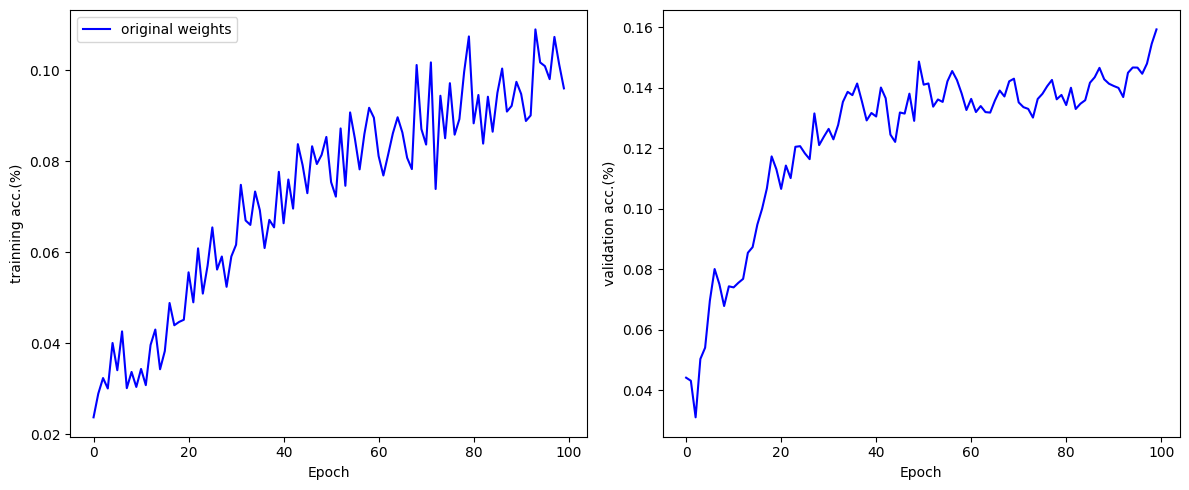

In [30]:
plt.figure(figsize=(12, 5))

# Primeiro gráfico: Acurácia de treino
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, 1º gráfico
plt.plot(acc_list_total, label='original weights', color='blue')
#, linestyle='dashed'
plt.xlabel("Epoch")
plt.ylabel("trainning acc.(%)")
plt.legend()

# Segundo gráfico: Acurácia de validação
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, 2º gráfico
plt.plot(val_list_total, label='Validation Accuracy', color='blue')
plt.xlabel("Epoch")
plt.ylabel("validation acc.(%)")
# plt.legend()

# Mostrar os gráficos
plt.tight_layout()  # Ajusta o layout automaticamente
plt.show()


In [31]:
# # 1 = sentimento positivo ou 0 = sentimento negativo

# model = mlp(input_size=input_size, n_classes = n_classes)
# model = model.to(device)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adadelta(model.parameters(), lr=0.1, rho=0.95, eps=1e-8)

## PA rewiring method

- @author: scabini

In [32]:
def rewiring_np(weights, seed):
    dimensions = weights.shape
    if seed:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()
    st = np.zeros(dimensions[1])
    for neuron in range(1,dimensions[0]): #loops over output neurons from 2 to n-1
        st = st + weights[neuron-1]   #compute the temporary strength
        P = st + np.abs(np.min(st)) + 1 #make the distribution positive and avoid null probability
        P = P / np.sum(P) #pdf from negative to positive
        targets = rng.choice(a=[i for i in range(dimensions[1])], replace=False,
                                      size=dimensions[1],p=P)
        edges_to_rewire = np.argsort(weights[neuron]) #sort the edges to be rewired
        weights[neuron, targets] = weights[neuron, edges_to_rewire] #rewiring
    return weights

In [33]:
def rewiring_torch(weights, seed):
    if seed:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()
    st = torch.zeros(weights.size(1))
    with torch.no_grad():
        dimensions = weights.shape
        for neuron in range(1,dimensions[0]):
            st = st + weights[neuron-1]
            P = st + torch.abs(torch.min(st)) + 1 #the +1 is to ensure no zero values
            P = P / torch.sum(P)
            targets = rng.choice(a=[i for i in range(dimensions[1])], replace=False,
                                          size=dimensions[1],p=P.cpu().detach().numpy())
            edges_to_rewire = torch.argsort(weights[neuron])
            weights[neuron, targets] = weights[neuron, edges_to_rewire]
    return weights

In [34]:
### Numpy version: has better numerical precision than the torch version;
#   however, it creates a copy of the weight tensor
def PA_rewiring_np(weights, seed=False):
    if weights.ndimension() < 2:
        raise ValueError("Only tensors with 2 or more dimensions are supported")
    output_neurons = weights.size(0)
    input_neurons = weights.numel() // output_neurons
    dimensions = weights.shape
    weights_out = weights.cpu().detach().numpy()
    weights_out = weights_out.reshape((output_neurons, input_neurons))
    rewiring_np(weights_out, seed) #rewire input neurons
    rewiring_np(np.transpose(weights_out), seed) #rewire output neurons
    weights_out = weights_out.reshape((dimensions))
    weights_out=torch.from_numpy(weights_out)
    with torch.no_grad():
        weights.view_as(weights_out).copy_(weights_out)
    return weights  #cast the obtained tensor into the input tensor 'weights'

In [35]:
### Pytorch implementation: looses precision on large sums compared to
#   numpy, i.e., the strength calculations will be different.
#   I recommend using the np version (but check efficiency)
def PA_rewiring_torch(weights, seed=False):
    if weights.ndimension() < 2:
        raise ValueError("Only tensors with 2 or more dimensions are supported")
    with torch.no_grad():
        output_neurons = weights.size(0)
        input_neurons = weights.numel() // output_neurons
        dimensions = weights.shape
        weights = weights.reshape((output_neurons, input_neurons))
        rewiring_torch(weights, seed)
        rewiring_torch(torch.transpose(weights, 0, 1), seed)
        weights = weights.reshape((dimensions))
    return weights  #cast the obtained tensor into the input tensor 'weights'

In [36]:
def stabilize_strength(initializer, weights, K=100): #how much stable? =) increase K!
### random search to minimize strength variance
#initializer is a lambda function that receives the weights, eg:
# initializer = lambda w : torch.nn.init.kaiming_normal_(w, mode='fan_in', nonlinearity='relu')
#or simply:
# initializer = torch.nn.init.orthogonal_
#weights is a torch weight matrix taken from a layer
    maximus = np.Infinity
    dimensions = weights.shape
    output_neurons = weights.size(0)
    input_neurons = weights.numel() // output_neurons
    weights_out = torch.empty(dimensions)
    for i in range(K):
        initializer(weights)
        weights = weights.reshape((output_neurons, input_neurons))
        localmax = torch.mean(torch.hstack((torch.var(torch.sum(weights, dim=0) ), torch.var(torch.sum(weights, dim=1) ))))
        if localmax < maximus:
            maximus = localmax
            with torch.no_grad():
                weights_out.view_as(weights).copy_(weights)

    with torch.no_grad():
        weights.view_as(weights_out.reshape(dimensions)).copy_(weights_out.reshape(dimensions))

    return weights


- Refazer a estrutura, mas agora aplicando a técnica do PARw

In [37]:
# model = mlp(input_size=input_size, n_classes = n_classes)
# model = model.to(device)

# for m in model.modules():
#     print(type(m))

In [38]:
def train_model_parw(seed):
    torch.manual_seed(seed)

    model = mlp(input_size=input_size, n_classes = n_classes)
    model = model.to(device)

    #########################
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
            PA_rewiring_np(m.weight)
    #########################

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters(), lr=0.1, rho=0.95, eps=1e-8)
    train_losses, val_losses, val_accuracies = [], [], []

    print(f'Teste da Seed: {seed}')
    best_model = model
    best_val_acc = 0
    train_metrics_list = []
    val_metrics_list = []
    for epoch in range(num_epochs):
        # Treinamento
        train_loss, train_acc = train_one_epoch(model, dataloader_train, optimizer, loss_fn, device)

        train_metrics_list.append((train_loss, train_acc))



        train_losses.append(train_loss)

        # Avaliação
        val_loss, val_acc = evaluate(model, dataloader_val, loss_fn, device)
        val_metrics_list.append((val_loss, val_acc))



        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model

        if (epoch + 1) == 50:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"  Train Loss: {train_loss:.4f}")
            print(f"  Validation Loss: {val_loss:.4f}")
            print(f"  Validation Accuracy: {val_acc:.4f}")

    test_loss, test_acc = evaluate(best_model, dataloader_test, loss_fn, device)

    return train_metrics_list, val_metrics_list, test_acc

In [39]:
acc_list.shape

(100,)

In [40]:
# Testando diferentes sementes
results = {}
acc_list_total_parw = np.zeros(100)
val_list_total_parw = np.zeros(100)

for seed in seeds:
    train_metrics_list, val_metrics_list, test_acc = train_model_parw(seed)
    train_acc_1, val_acc_1 = train_metrics_list[0][1], val_metrics_list[0][1]

    acc_list = np.array([train_metrics_list[i][1] for i in range(len(train_metrics_list))])
    acc_list_total_parw = (1/2)*(acc_list_total_parw + acc_list)

    val_list = np.array([val_metrics_list[i][1] for i in range(len(val_metrics_list))])
    val_list_total_parw = (1/2)*(val_list_total_parw + val_list)

    results[seed] = train_acc_1, val_acc_1, test_acc
    print(f"Semente: {seed}, train_acc_1: {train_acc_1:.4f}, val_acc_1: {val_acc_1:.4f}, test_acc {test_acc:.4f}")

Teste da Seed: 0
Epoch 50/100
  Train Loss: 3.6716
  Validation Loss: 3.3044
  Validation Accuracy: 0.1641
Semente: 0, train_acc_1: 0.0103, val_acc_1: 0.0205, test_acc 0.1684
Teste da Seed: 1
Epoch 50/100
  Train Loss: 3.5913
  Validation Loss: 3.3729
  Validation Accuracy: 0.1385
Semente: 1, train_acc_1: 0.0282, val_acc_1: 0.0205, test_acc 0.1378
Teste da Seed: 2
Epoch 50/100
  Train Loss: 3.5997
  Validation Loss: 3.2901
  Validation Accuracy: 0.1333
Semente: 2, train_acc_1: 0.0256, val_acc_1: 0.0513, test_acc 0.1786
Teste da Seed: 3
Epoch 50/100
  Train Loss: 3.6152
  Validation Loss: 3.3448
  Validation Accuracy: 0.1897
Semente: 3, train_acc_1: 0.0256, val_acc_1: 0.0256, test_acc 0.1837
Teste da Seed: 4
Epoch 50/100
  Train Loss: 3.5207
  Validation Loss: 3.3350
  Validation Accuracy: 0.1744
Semente: 4, train_acc_1: 0.0103, val_acc_1: 0.0513, test_acc 0.1378
Teste da Seed: 5
Epoch 50/100
  Train Loss: 3.6125
  Validation Loss: 3.3787
  Validation Accuracy: 0.1744
Semente: 5, train_

In [41]:
# results = {}
# for seed in seeds:
#     train_acc_1, val_acc_1, test_acc = train_model_parw(seed)
#     results[seed] = train_acc_1, val_acc_1, test_acc
#     print(f"Semente: {seed}, train_acc_1: {train_acc_1:.4f}, val_acc_1: {val_acc_1:.4f}, test_acc {test_acc:.4f}")

In [42]:
# Resultados finais
print("\nResultados por semente:")
train_acc_1_list = []
val_acc_1_list = []
test_acc_list = []
for seed, accs in results.items():
    print(f"Semente: {seed}, train_acc_1: {accs[0]:.4}, val_acc_1: {accs[1]:.4}, test_acc {accs[2]:.4}")
    train_acc_1_list.append(accs[0])
    val_acc_1_list.append(accs[1])
    test_acc_list.append(accs[2])


Resultados por semente:
Semente: 0, train_acc_1: 0.01026, val_acc_1: 0.02051, test_acc 0.1684
Semente: 1, train_acc_1: 0.02821, val_acc_1: 0.02051, test_acc 0.1378
Semente: 2, train_acc_1: 0.02564, val_acc_1: 0.05128, test_acc 0.1786
Semente: 3, train_acc_1: 0.02564, val_acc_1: 0.02564, test_acc 0.1837
Semente: 4, train_acc_1: 0.01026, val_acc_1: 0.05128, test_acc 0.1378
Semente: 5, train_acc_1: 0.01282, val_acc_1: 0.02051, test_acc 0.1173
Semente: 6, train_acc_1: 0.0359, val_acc_1: 0.0359, test_acc 0.1531
Semente: 7, train_acc_1: 0.02051, val_acc_1: 0.02564, test_acc 0.1786
Semente: 8, train_acc_1: 0.04872, val_acc_1: 0.04103, test_acc 0.2194
Semente: 9, train_acc_1: 0.03333, val_acc_1: 0.02564, test_acc 0.1582
Semente: 10, train_acc_1: 0.02564, val_acc_1: 0.06154, test_acc 0.1888
Semente: 11, train_acc_1: 0.01538, val_acc_1: 0.03077, test_acc 0.1633
Semente: 12, train_acc_1: 0.02821, val_acc_1: 0.03077, test_acc 0.1939
Semente: 13, train_acc_1: 0.03333, val_acc_1: 0.0359, test_acc 0

In [43]:
train_acc_1_pwd_mean, val_acc_1_pwd_mean, test_acc_pwd_mean = np.mean(train_acc_1_list), np.mean(val_acc_1_list), np.mean(test_acc_list)
train_acc_1_pwd_std, val_acc_1_pwd_std, test_acc_pwd_std = np.std(train_acc_1_list), np.std(val_acc_1_list), np.std(test_acc_list)

In [44]:
print(f"Média de train_acc_1: {train_acc_1_pwd_mean:.4f}, Desvio padrão: {train_acc_1_pwd_std:.4f}")
print(f"Média de val_acc_1: {val_acc_1_pwd_mean:.4f}, Desvio padrão: {val_acc_1_pwd_std:.4f}")
print(f"Média de test_acc: {test_acc_pwd_mean:.4f}, Desvio padrão: {test_acc_pwd_std:.4f}")

Média de train_acc_1: 0.0258, Desvio padrão: 0.0085
Média de val_acc_1: 0.0301, Desvio padrão: 0.0146
Média de test_acc: 0.1729, Desvio padrão: 0.0233


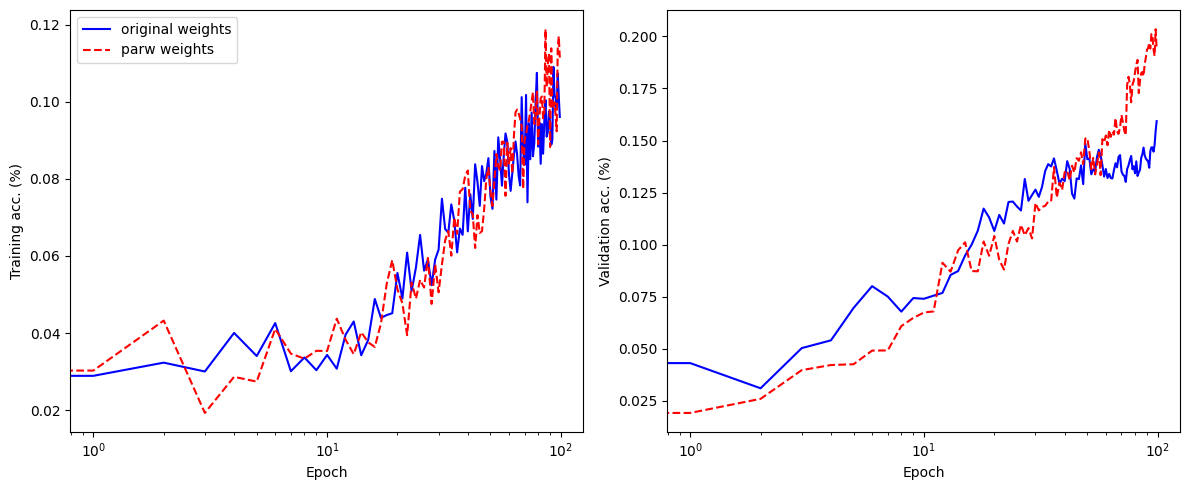

In [45]:
plt.figure(figsize=(12, 5))

# Primeiro gráfico: Acurácia de treino
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, 1º gráfico
plt.plot(acc_list_total, label='original weights', color='blue')
plt.plot(acc_list_total_parw, label='parw weights', color='red', linestyle='dashed')
plt.xscale('log')  # Escala logarítmica no eixo x
plt.xlabel("Epoch")
plt.ylabel("Training acc. (%)")
plt.legend()

# Segundo gráfico: Acurácia de validação
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, 2º gráfico
plt.plot(val_list_total, label='Validation Accuracy', color='blue')
plt.plot(val_list_total_parw, label='parw weights', color='red', linestyle='dashed')
plt.xscale('log')  # Escala logarítmica no eixo x
plt.xlabel("Epoch")
plt.ylabel("Validation acc. (%)")

# Mostrar os gráficos
plt.tight_layout()  # Ajusta o layout automaticamente

plt.savefig('mlp_adiac.png', dpi=300)
plt.show()

In [46]:
print(f"Média de train_acc_normal_1: {train_acc_1_mean:.4f}, Desvio padrão: {train_acc_1_std:.4f}")
print(f"Média de val_acc_normal_1: {val_acc_1_mean:.4f}, Desvio padrão: {val_acc_1_std:.4f}")
print(f"Média de test_acc_normal: {test_acc_mean:.4f}, Desvio padrão: {test_acc_std:.4f}")
print("\n################\n")
print(f"Média de train_acc_1: {train_acc_1_pwd_mean:.4f}, Desvio padrão: {train_acc_1_pwd_std:.4f}")
print(f"Média de val_acc_1: {val_acc_1_pwd_mean:.4f}, Desvio padrão: {val_acc_1_pwd_std:.4f}")
print(f"Média de test_acc: {test_acc_pwd_mean:.4f}, Desvio padrão: {test_acc_pwd_std:.4f}")

Média de train_acc_normal_1: 0.0258, Desvio padrão: 0.0082
Média de val_acc_normal_1: 0.0273, Desvio padrão: 0.0155
Média de test_acc_normal: 0.1607, Desvio padrão: 0.0228

################

Média de train_acc_1: 0.0258, Desvio padrão: 0.0085
Média de val_acc_1: 0.0301, Desvio padrão: 0.0146
Média de test_acc: 0.1729, Desvio padrão: 0.0233
